<a href="https://colab.research.google.com/github/selahattinozturk/Urbansound-Classification/blob/main/softmax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
CUR_PATH = '/content/drive/My Drive/EEE485'

Mounted at /content/drive


In [ ]:
classes = ["air_conditioner", "car_horn", "children_playing", "dog_bark", "drilling", "engine_idling", "gun_shot", "jackhammer", "siren", "street_music"]
class_idx = {c: i for i, c in enumerate(classes)}

In [ ]:
def onehot_encoder(y_train):
  onehot_y_train = []
  for yi in y_train:
    onehot_yi = [0 for i in range(len(classes))]
    onehot_yi[class_idx[yi]] = 1
    onehot_y_train.append(onehot_yi)

  return np.array(onehot_y_train).copy()

In [ ]:
def standardize_data(X_train, X_test):
  mean = np.mean(X_train, axis=0)
  std = np.std(X_train, axis=0)
  X_train = (X_train - mean) / std
  X_test = (X_test - mean) / std
  return X_train, X_test

In [ ]:
def import_data(cv_idx): # cv_index = {0, 1, .., 9}
  names = [f'fold{i}.csv' for i in range(1, 11)]
  X_train = []
  X_test = []
  y_train = []
  y_test = []
  for f_idx, name in enumerate(names):
    fold_data = pd.read_csv(f'{CUR_PATH}/data/{name}', index_col=0)
    fold_X = fold_data.drop(["filename", "class"], axis=1)
    # fold_X = fold_X.drop([f"mfcc_min{i}" for i in range(1, 26)], axis=1)
    # fold_X = fold_X.drop([f"mfcc_max{i}" for i in range(1, 26)], axis=1)
    fold_y = fold_data['class'].values.tolist()
    fold_X = fold_X.values.tolist()
    if f_idx == cv_idx:
      X_test.extend(fold_X)
      y_test.extend(fold_y)
    else:
      X_train.extend(fold_X)
      y_train.extend(fold_y)
  
  return np.array(X_train).copy(), np.array(X_test).copy(), y_train, y_test

In [ ]:
def prepare_dataset(cv_idx):
  X_train, X_test, y_train, y_test = import_data(cv_idx)
  X_train, X_test = standardize_data(X_train, X_test)
  y_train, y_test = onehot_encoder(y_train), onehot_encoder(y_test)
  X_train, X_test = pca(X_train, X_test)  
  X_train = np.insert(X_train, 0, 1, axis=1)
  X_test = np.insert(X_test, 0, 1, axis=1)
  return X_train, X_test, y_train, y_test

In [ ]:
import matplotlib.pyplot as plt

def pca(X_train, X_test): # X must be standardized
  CUTOFF = 90
  n, p = X_train.shape
  total_variance = (np.linalg.norm(X_train, ord="fro") ** 2) / n
  sigma = (X_train.T @ X_train) / n
  w, v = np.linalg.eig(sigma)
  w_argsort = w.argsort()[::-1]
  w[::-1].sort()
  v = v[w_argsort]
  pve_first_k = 0

  project_X_train = X_train @ v
  pve_first_k_all = np.zeros((len(v),1))
  needed_k = []

  for eig_idx in range(len(w)):
    pve_first_k += (project_X_train[:,eig_idx].T @ project_X_train[:,eig_idx]) / (n * total_variance)
    pve_first_k_all[eig_idx] = pve_first_k
    if pve_first_k > CUTOFF / 100:
      needed_k.append(eig_idx)

  k = needed_k[0]
  u = v[:,:k]
  X_train = X_train @ u
  X_test = X_test @ u

  '''  plt.plot(np.linspace(1, p, p),100 * pve_first_k_all)
  plt.title('# of PC vs. PVE (%)\n'
            '# of PC where PVE exceeds {0:d}% first time: {1:d}'.format(CUTOFF,k))
  plt.xlabel('# of PC')
  plt.ylabel('PVE (%)')
  plt.plot(k, 100 * pve_first_k_all[k],'rx')
  plt.plot(np.linspace(1, p, p), CUTOFF * np.ones(p),'r--')
  '''
  return X_train, X_test


In [ ]:
def softmax(u):
  u = np.exp(u)
  return u / np.sum(u)

In [ ]:
def loss(p, q):
  return -np.dot(p, np.log(q))

In [ ]:
def trackLoss(X, Y, beta):
  n = X.shape[0]
  L = .0

  for i in range(n):
    qi = softmax(beta @ X[i])
    L += loss(Y[i], qi)

  return L

In [ ]:
def stochastic_gd(X, Y, epochs=10, lr=0.01, decay=0.1):
  n, p = X.shape
  beta = np.zeros((Y.shape[1], p))
  losses = []
  prev_loss = 1e15
  last_epoch = 0

  test_acc = 0
  for epoch in range(epochs):
    perm = np.random.permutation(n)
    for i in perm:
      qi = softmax(beta @ X[i])
      dLi = np.outer(qi - Y[i], X[i])
      beta -= (lr)* (1/(i*decay+1)) * dLi # lr/p

    cur_loss = trackLoss(X, Y, beta)
    losses.append(cur_loss)

    if (prev_loss - cur_loss) < (prev_loss / 1000):
      break

    prev_loss = cur_loss
    last_epoch += 1

  return beta, losses, last_epoch


In [ ]:
def predict(X, beta):
  n = X.shape[0]
  preds = np.zeros((n, 1))
  for i in range(n):
    qi = softmax(beta @ X[i])
    k = np.argmax(qi)
    preds[i] = k

  return preds

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def eval_metrics(y_preds, y_true):
  k = len(classes)
  conf_matrix = np.zeros((k, k), dtype=int)
  for i in range(len(y_preds)):
    conf_matrix[y_true[i], y_preds[i]] += 1

  acc = (y_preds == y_true).sum() / len(y_preds)
  
  precision, recall, f1 = np.zeros(k), np.zeros(k), np.zeros(k)

  for j in range(k):
    precision[j] = conf_matrix[j, j] / np.sum(conf_matrix[:, j])
    recall[j] = conf_matrix[j, j] / np.sum(conf_matrix[j, :])
    f1[j] = 2 * precision[j] * recall[j] / (precision[j] + recall[j])

  sns.heatmap(conf_matrix, annot=True)
  plt.show()

  return acc, precision, recall, f1

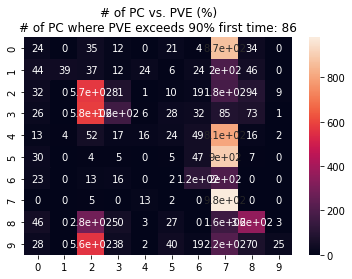

Epoch: 50 with last epoch 49, Learning rate: 0.0001, Decay: 1, Test Accuracy: 0.264, Time: 172.221 seconds


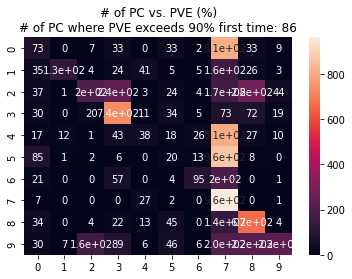

Epoch: 50 with last epoch 50, Learning rate: 0.0001, Decay: 0.1, Test Accuracy: 0.361, Time: 187.108 seconds


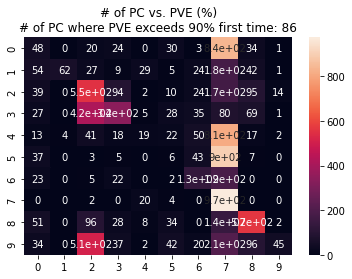

Epoch: 50 with last epoch 50, Learning rate: 0.0005, Decay: 1, Test Accuracy: 0.314, Time: 172.633 seconds


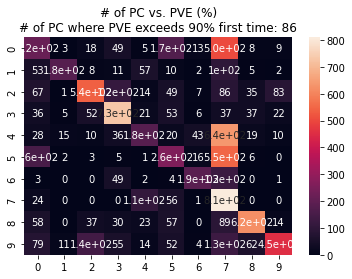

Epoch: 50 with last epoch 50, Learning rate: 0.0005, Decay: 0.1, Test Accuracy: 0.480, Time: 187.413 seconds


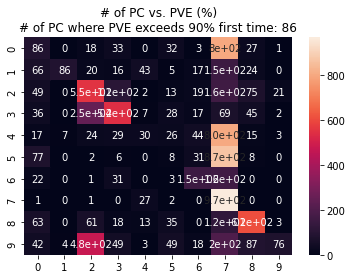

Epoch: 50 with last epoch 50, Learning rate: 0.001, Decay: 1, Test Accuracy: 0.357, Time: 173.400 seconds


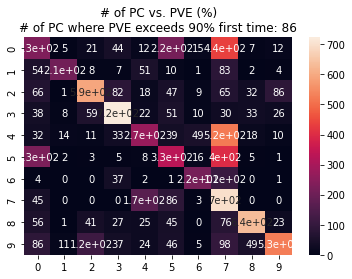

Epoch: 50 with last epoch 50, Learning rate: 0.001, Decay: 0.1, Test Accuracy: 0.509, Time: 189.327 seconds


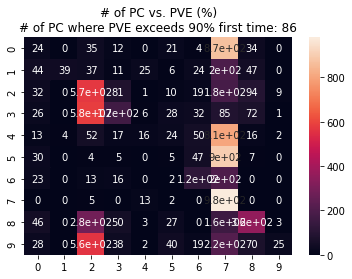

Epoch: 100 with last epoch 49, Learning rate: 0.0001, Decay: 1, Test Accuracy: 0.264, Time: 176.098 seconds


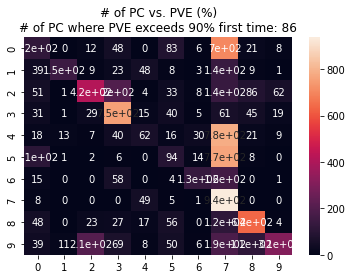

Epoch: 100 with last epoch 100, Learning rate: 0.0001, Decay: 0.1, Test Accuracy: 0.414, Time: 374.228 seconds


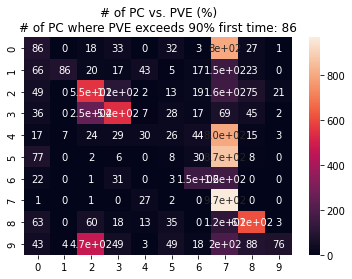

Epoch: 100 with last epoch 100, Learning rate: 0.0005, Decay: 1, Test Accuracy: 0.357, Time: 345.365 seconds


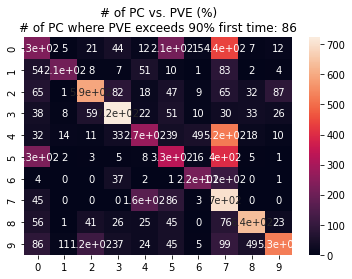

Epoch: 100 with last epoch 100, Learning rate: 0.0005, Decay: 0.1, Test Accuracy: 0.509, Time: 373.049 seconds


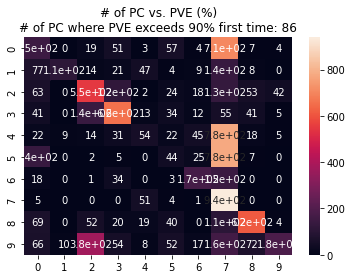

Epoch: 100 with last epoch 100, Learning rate: 0.001, Decay: 1, Test Accuracy: 0.398, Time: 345.128 seconds


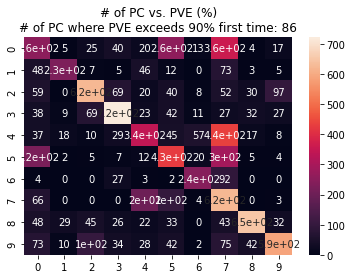

Epoch: 100 with last epoch 100, Learning rate: 0.001, Decay: 0.1, Test Accuracy: 0.540, Time: 372.564 seconds


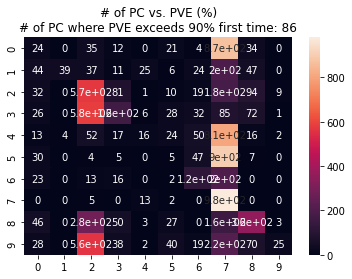

Epoch: 500 with last epoch 49, Learning rate: 0.0001, Decay: 1, Test Accuracy: 0.264, Time: 176.167 seconds


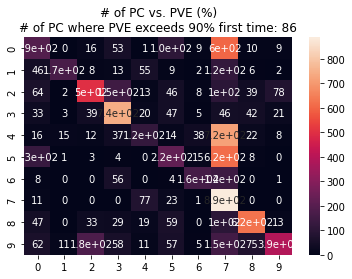

Epoch: 500 with last epoch 165, Learning rate: 0.0001, Decay: 0.1, Test Accuracy: 0.460, Time: 620.771 seconds


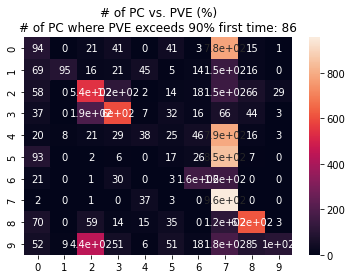

Epoch: 500 with last epoch 127, Learning rate: 0.0005, Decay: 1, Test Accuracy: 0.370, Time: 450.804 seconds


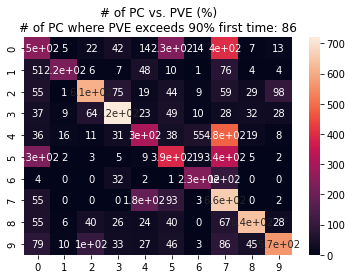

Epoch: 500 with last epoch 138, Learning rate: 0.0005, Decay: 0.1, Test Accuracy: 0.527, Time: 534.156 seconds


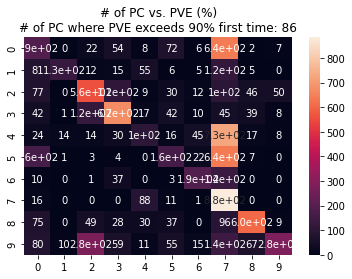

Epoch: 500 with last epoch 152, Learning rate: 0.001, Decay: 1, Test Accuracy: 0.432, Time: 528.426 seconds


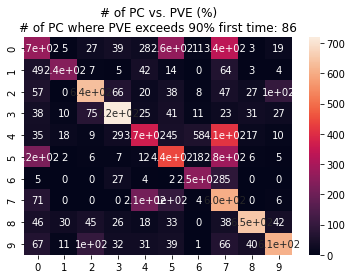

Epoch: 500 with last epoch 123, Learning rate: 0.001, Decay: 0.1, Test Accuracy: 0.549, Time: 478.661 seconds


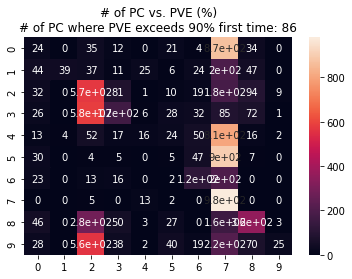

Epoch: 1000 with last epoch 49, Learning rate: 0.0001, Decay: 1, Test Accuracy: 0.264, Time: 176.148 seconds


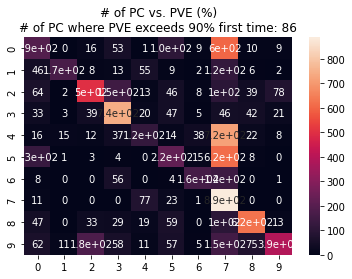

Epoch: 1000 with last epoch 166, Learning rate: 0.0001, Decay: 0.1, Test Accuracy: 0.460, Time: 621.926 seconds


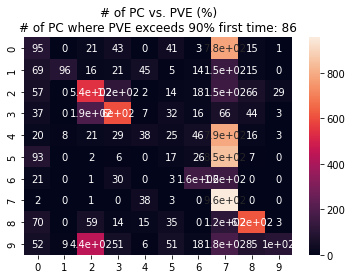

Epoch: 1000 with last epoch 128, Learning rate: 0.0005, Decay: 1, Test Accuracy: 0.370, Time: 449.250 seconds


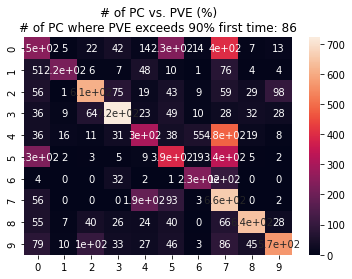

Epoch: 1000 with last epoch 138, Learning rate: 0.0005, Decay: 0.1, Test Accuracy: 0.527, Time: 527.954 seconds


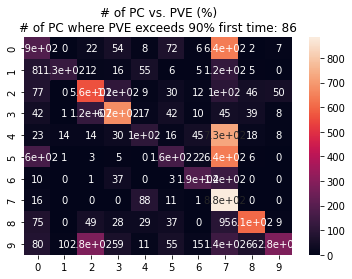

Epoch: 1000 with last epoch 150, Learning rate: 0.001, Decay: 1, Test Accuracy: 0.432, Time: 518.033 seconds


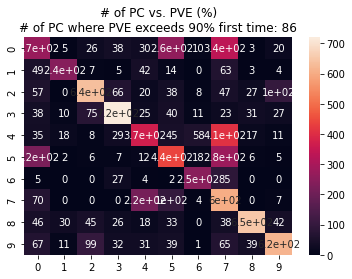

Epoch: 1000 with last epoch 124, Learning rate: 0.001, Decay: 0.1, Test Accuracy: 0.550, Time: 473.420 seconds
[]


In [ ]:
from timeit import default_timer as timer
from pprint import pprint

our_acc = []
epochs = [50, 100, 500, 1000]
lrs = [0.0001, 0.0005, 0.001]
decays = [1, 0.1] # , 0.01
output_lines = []

for epoch in epochs:
  for lr in lrs:
    for decay in decays:   
      corrects = 0
      lengths = 0
      time = 0
      y_preds = []
      y_true = []
      for fold_idx in range(0, 10):
        X_train, X_test, y_train, y_test = prepare_dataset(fold_idx)
        start = timer()
        beta, _, last_epoch = stochastic_gd(X_train, y_train, epochs=epoch, lr=lr, decay=decay)
        end = timer()
        time += end - start
        preds = predict(X_test, beta).flatten().astype(int)
        trues = np.argmax(y_test, axis=1)
        y_preds.append(preds)
        y_true.append(trues)

      y_preds = np.concatenate(y_preds, axis=None)
      y_true = np.concatenate(y_true, axis=None)

      acc, precision, recall, f1 = eval_metrics(y_preds, y_true)

      avg_time = time
      print(f'Epoch: {epoch} with last epoch {last_epoch}, Learning rate: {lr}, Decay: {decay}, Test Accuracy: {acc:.3f}, Time: {avg_time:.3f} seconds')
      output_lines.append(f'Epoch: {epoch} Learning rate: {lr}, Decay: {decay}, Test Accuracy: {acc:.3f}, Time: {avg_time:.3f}')

pprint(our_acc)

Epoch: 10 Learning rate: 0.0001, Decay: 1, Test Accuracy: 0.4914671858893597
Epoch: 10 Learning rate: 0.0001, Decay: 0.1, Test Accuracy: 0.41942503722368574
Epoch: 10 Learning rate: 0.0005, Decay: 1, Test Accuracy: 0.4875730156912152
Epoch: 10 Learning rate: 0.0005, Decay: 0.1, Test Accuracy: 0.47944107204214864
Epoch: 10 Learning rate: 0.001, Decay: 1, Test Accuracy: 0.4843660519986256
Epoch: 10 Learning rate: 0.001, Decay: 0.1, Test Accuracy: 0.5201007902874814
Epoch: 50 Learning rate: 0.0001, Decay: 1, Test Accuracy: 0.4873439468560302
Epoch: 50 Learning rate: 0.0001, Decay: 0.1, Test Accuracy: 0.4793265376245562
Epoch: 50 Learning rate: 0.0005, Decay: 1, Test Accuracy: 0.4867712747680678
Epoch: 50 Learning rate: 0.0005, Decay: 0.1, Test Accuracy: 0.5635093345550338
Epoch: 50 Learning rate: 0.001, Decay: 1, Test Accuracy: 0.510594433627305
Epoch: 50 Learning rate: 0.001, Decay: 0.1, Test Accuracy: 0.5884778375901959
Epoch: 100 Learning rate: 0.0001, Decay: 1, Test Accuracy: 0.485282

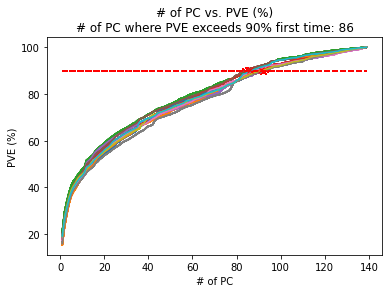

In [ ]:
from pprint import pprint

our_acc = []
epochs = [10, 50, 100]
lrs = [0.0001, 0.0005, 0.001]
decays = [1, 0.1] # , 0.01
output_lines = []
for epoch in epochs:
  for lr in lrs:
    for decay in decays:   
      corrects = 0
      lengths = 0
      for fold_idx in range(0, 10):
        X_train, X_test, y_train, y_test = prepare_dataset(fold_idx)
        beta, _, correct, length = stochastic_gd(X_train, y_train, X_test, y_test, epochs=epoch, lr=lr, decay=decay)
        corrects += correct
        lengths += length

      print(f'Epoch: {epoch} Learning rate: {lr}, Decay: {decay}, Test Accuracy:', corrects / lengths)
      output_lines.append(f'Epoch: {epoch} Learning rate: {lr}, Decay: {decay}, Test Accuracy: {corrects / lengths}')

pprint(our_acc)

In [ ]:
f = open(f'{CUR_PATH}/sgd_data_out.txt', "w+")
f.write('\n'.join(output_lines))
f.close()